<a href="https://colab.research.google.com/github/OJB-Quantum/Quantum-Native-Solvers/blob/main/Colab%20Example%20Notebooks/Dy_Low_Temperature_Magnetization_Prediction_Qiskit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [ ]:
# --------------------------------------------------------------
# 0) Colab environment: install Qiskit + Aer GPU (CUDA 12) wheels
# --------------------------------------------------------------
# If you're in a *fresh* GPU runtime, uncomment the pip cell below.

%pip uninstall -y qiskit-aer qiskit > /dev/null 2>&1
%pip install "qiskit>=1.1.0,<2.0" "qiskit-aer-gpu==0.15.1" numpy scipy matplotlib pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 119.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 123.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 137.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.1/237.1 MB 3.1 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=4c878fc1d9c534a86d68a535f475c91d29a244815c55477723146cde1701b767
  Stored in 

In [ ]:
# --------------------------------------------------------------
# 1) Imports and constants
# --------------------------------------------------------------
from __future__ import annotations

from dataclasses import dataclass, replace
from typing import Dict, List, Tuple

import math
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 200

# Qiskit Aer (GPU-capable) + noise
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, QuantumError
from qiskit.quantum_info import Kraus
from qiskit.circuit.library import UnitaryGate
from qiskit import QuantumCircuit, transpile

# SciPy for high-quality expm
from scipy.linalg import expm

# Physical constants (eV-based units)
HBAR = 6.582_119_569e-16     # eV·s
MU_B = 5.788_381_806e-5      # eV/T
K_B  = 8.617_333_262_145e-5  # eV/K

In [ ]:
# --------------------------------------------------------------
# 2) "Control knobs" — Dy model + sweep parameters (adjust freely)
# --------------------------------------------------------------
@dataclass
class Params:
    # Dy3+ giant spin: J=15/2 => d=16 (=4 qubits)
    J: float = 15.0/2.0

    # Crystal-field anisotropy (eV)
    D_eV: float = -1.0e-3
    E_eV: float =  0.02e-3

    # g-factors and static field (Tesla)
    g_par: float = 19.0
    g_perp: float = 0.5
    B_T: Tuple[float, float, float] = (0.0, 0.0, 0.2)

    # Time stepping
    dt_s: float = 2.0e-6
    t_final_s: float = 4.0e-3

    # Linear temperature sweep (edit as needed)
    temp_min_K: float = 0.25
    temp_max_K: float = 150.0
    num_temps: int = 121

    # Relaxation and dephasing prefactors (1/s)
    gamma0_relax: float = 2.0e8
    raman_n: int = 7
    Ueff_eV: float = 0.020
    gamma_phi0: float = 2.0e7

    # Kraus numerics
    kraus_atol: float = 1e-10
    kraus_clamp: float = 1e-9
    kraus_max_terms: int = 0  # 0 => use full Kraus set

    # Onset thresholds for reporting m(T) crossings
    onset_thresholds: Tuple[float, float] = (0.5, 0.9)

KNOBS = Params()


In [ ]:
# --------------------------------------------------------------
# 3) Spin matrices, Hamiltonian, and helpers
# --------------------------------------------------------------
def spin_matrices(J: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return (Jx, Jy, Jz) in the |m> basis for a spin-J system."""
    m = np.arange(J, -J-1, -1, dtype=float)  # J, J-1, ..., -J
    d = m.size
    Jp = np.zeros((d, d), dtype=complex)
    for i in range(d-1):
        Jp[i, i+1] = math.sqrt((J - m[i])*(J + m[i] + 1))
    Jm = Jp.conj().T
    Jx = 0.5*(Jp + Jm)
    Jy = -0.5j*(Jp - Jm)
    Jz = np.diag(m)
    return Jx, Jy, Jz

def dy_hamiltonian(p: Params) -> np.ndarray:
    """H = D Jz^2 + E (Jx^2 - Jy^2) + μB (g·B)·J   in eV."""
    Jx, Jy, Jz = spin_matrices(p.J)
    h_cf = p.D_eV*(Jz@Jz) + p.E_eV*(Jx@Jx - Jy@Jy)
    gx, gy, gz = p.g_perp, p.g_perp, p.g_par
    Bx, By, Bz = p.B_T
    h_z = MU_B*(gx*Bx*Jx + gy*By*Jy + gz*Bz*Jz)
    return (h_cf + h_z).astype(complex)

def _coth_safe(x: float) -> float:
    if x <= 1e-6:
        return 1.0/x + x/3.0 - (x**3)/45.0
    if x >= 20.0:
        return 1.0 + 2.0*math.exp(-2.0*x)
    return 1.0/math.tanh(x)

def relaxation_and_dephasing(h_eV: np.ndarray, p: Params, T_K: float) -> Tuple[float, float]:
    """γ_relax(T), γ_phi(T) in 1/s using direct + Raman + Orbach scaling."""
    evals = np.linalg.eigvalsh(h_eV)
    evals = np.sort(evals)
    w0 = abs(evals[1]-evals[0])/HBAR if evals.size >= 2 else 1.0e9

    x = (HBAR*w0)/(2.0*K_B*max(T_K, 1e-12))
    direct = p.gamma0_relax * w0 * _coth_safe(x) / 1e12
    raman  = p.gamma0_relax * (max(T_K, 1e-12)**p.raman_n)
    orbach = p.gamma0_relax * math.exp(-p.Ueff_eV/(K_B*max(T_K, 1e-12)))

    gamma_relax = float(direct + raman + orbach)
    gamma_phi   = float(p.gamma_phi0 + 0.05*raman)
    return gamma_relax, gamma_phi


In [ ]:
# --------------------------------------------------------------
# 4) Size scaling (molecules vs nanoparticles)
# --------------------------------------------------------------
def scale_params_for_size(
    d_nm: float,
    base: Params,
    ref_nm: float = 10.0,
    anis_exp: float = 3.0,  # D,E ∝ d^{+3}
    relax_exp: float = 2.0, # γ  ∝ d^{−2}
    dt_scale: bool = False
) -> Params:
    if d_nm <= 0.0:
        raise ValueError("diameter must be > 0")
    new = replace(base)
    scale_anis  = (d_nm/ref_nm)**anis_exp
    scale_relax = (ref_nm/d_nm)**relax_exp
    new.D_eV = base.D_eV*scale_anis
    new.E_eV = base.E_eV*scale_anis
    new.gamma0_relax = base.gamma0_relax*scale_relax
    new.gamma_phi0   = base.gamma_phi0*scale_relax
    if dt_scale:
        new.dt_s = base.dt_s*(d_nm/ref_nm)
    return new


In [ ]:
# --------------------------------------------------------------
# 5) Collision-model CPTP (Kraus) channels
# --------------------------------------------------------------
def gibbs_probs(energies_eV: np.ndarray, T_K: float) -> np.ndarray:
    if T_K <= 0.0:
        p = np.zeros_like(energies_eV, dtype=float)
        p[np.argmin(energies_eV)] = 1.0
        return p
    e_shift = energies_eV - np.min(energies_eV)
    beta = 1.0/(K_B*T_K)
    w = np.exp(-beta*e_shift)
    return w/np.sum(w)

def kraus_reset_to_gibbs(energies, V, T_K, eps) -> List[np.ndarray]:
    d = energies.size
    pi = gibbs_probs(energies, T_K)
    K0 = np.sqrt(max(0.0, 1.0-eps)) * np.eye(d, dtype=complex)
    ops = [K0]
    scale = np.sqrt(max(0.0, eps)/d)
    for i in range(d):
        for j in range(d):
            K = np.zeros((d,d), dtype=complex)
            K[i,j] = scale*np.sqrt(pi[i])
            ops.append(K)
    Vdag = V.conj().T
    return [V @ K @ Vdag for K in ops]

def kraus_multilevel_dephasing(energies, V, pphi) -> List[np.ndarray]:
    d = energies.size
    K0 = np.sqrt(max(0.0, 1.0-pphi))*np.eye(d, dtype=complex)
    ops = [K0]
    for i in range(d):
        K = np.zeros((d,d), dtype=complex)
        K[i,i] = np.sqrt(max(0.0, pphi))
        ops.append(K)
    Vdag = V.conj().T
    return [V @ K @ Vdag for K in ops]

def compose_kraus(first: List[np.ndarray], second: List[np.ndarray]) -> List[np.ndarray]:
    return [K1 @ K2 for K1 in first for K2 in second]

def enforce_cptp(kops: List[np.ndarray], atol: float=1e-10) -> List[np.ndarray]:
    d = kops[0].shape[0]
    S = np.zeros((d,d), dtype=complex)
    for K in kops:
        S += K.conj().T @ K
    S = 0.5*(S + S.conj().T)
    eig, _ = np.linalg.eigh(S)
    lam_max = float(eig.max())
    if lam_max > 1.0 + atol:
        scale = 1.0/math.sqrt(lam_max)
        kops = [scale*K for K in kops]
        S = np.zeros((d,d), dtype=complex)
        for K in kops:
            S += K.conj().T @ K
        S = 0.5*(S + S.conj().T)
    Delta = np.eye(d, dtype=complex) - S
    Delta = 0.5*(Delta + Delta.conj().T)
    ev, U = np.linalg.eigh(Delta)
    evp = np.clip(ev, 0.0, None)
    if float(evp.max()) > atol:
        extra = U @ np.diag(np.sqrt(evp)) @ U.conj().T
        kops.append(extra)
    return kops


In [ ]:
# --------------------------------------------------------------
# 6) Aer NoiseModel with (dephase ∘ Gibbs-reset) after each unitary
# --------------------------------------------------------------
def build_noise_model(h_eV: np.ndarray, T_K: float, p: Params) -> NoiseModel:
    energies, V = np.linalg.eig(h_eV)

    gamma_relax, gamma_phi = relaxation_and_dephasing(h_eV, p, T_K)
    dt = p.dt_s
    eps  = 1.0 - math.exp(-dt*min(gamma_relax, 1e12))
    pphi = 1.0 - math.exp(-dt*min(gamma_phi,   1e12))

    eps  = float(np.clip(eps,  p.kraus_clamp, 1.0 - p.kraus_clamp))
    pphi = float(np.clip(pphi, p.kraus_clamp, 1.0 - p.kraus_clamp))

    K_reset = kraus_reset_to_gibbs(energies, V, T_K, eps)
    K_deph  = kraus_multilevel_dephasing(energies, V, pphi)
    K_total = compose_kraus(K_deph, K_reset)
    K_total = enforce_cptp(K_total, atol=p.kraus_atol)

    num_qubits = int(np.log2(h_eV.shape[0]))
    targets = list(range(num_qubits))

    if p.kraus_max_terms and p.kraus_max_terms > 0:
        from qiskit_aer.utils import approximate_quantum_error
        qe_full = QuantumError(Kraus(K_total))
        qe_approx = approximate_quantum_error(qe_full, operator="kraus",
                                              num_terms=min(p.kraus_max_terms, len(K_total)))
        nm = NoiseModel()
        nm.add_quantum_error(qe_approx, ["unitary"], targets)
        return nm

    nm = NoiseModel()
    nm.add_quantum_error(QuantumError(Kraus(K_total)), ["unitary"], targets)
    return nm


In [ ]:
# --------------------------------------------------------------
# 7) Exact short-step unitary and observables
# --------------------------------------------------------------
def unitary_gate(h_eV: np.ndarray, dt_s: float) -> UnitaryGate:
    U = expm(-1j*h_eV*(dt_s/HBAR))
    return UnitaryGate(U)

def normalized_order_parameter(rho: np.ndarray, p: Params) -> float:
    _, _, Jz = spin_matrices(p.J)
    jz = float(np.real(np.trace(rho @ Jz)))
    return min(1.0, max(0.0, abs(jz)/p.J))


In [ ]:
# --------------------------------------------------------------
# 8) GPU Aer backend helper
# --------------------------------------------------------------
def get_aer_backend() -> AerSimulator:
    try:
        sim = AerSimulator(method="density_matrix", device="GPU")
        # Optional: show available devices
        try:
            print("Aer GPU available devices:", sim.available_devices())
        except Exception:
            pass
        return sim
    except Exception as exc:
        print("GPU backend not available → using CPU. Reason:", type(exc).__name__, exc)
        return AerSimulator(method="density_matrix")


In [ ]:
# --------------------------------------------------------------
# 9) Single-temperature propagation and size handling
# --------------------------------------------------------------
def simulate_state_for_temperature(T_K: float, p: Params) -> np.ndarray:
    h = dy_hamiltonian(p)
    u_gate = unitary_gate(h, p.dt_s)
    noise  = build_noise_model(h, T_K, p)

    n_steps = int(math.ceil(p.t_final_s/p.dt_s))
    nq = int(np.log2(h.shape[0]))
    qc = QuantumCircuit(nq, name=f"Dy_T_{T_K:.3g}K")
    for _ in range(n_steps):
        qc.append(u_gate, qc.qubits)
    qc.save_density_matrix()

    backend = get_aer_backend()
    comp = transpile(qc, backend=backend, optimization_level=0)
    res = backend.run(comp, noise_model=noise, shots=1).result()
    rho = np.array(res.data(comp)["density_matrix"], dtype=complex)
    return rho

def m_order_for_temperature(T_K: float, p: Params) -> float:
    rho = simulate_state_for_temperature(T_K, p)
    return normalized_order_parameter(rho, p)

def linear_temperature_grid(p: Params) -> np.ndarray:
    return np.linspace(p.temp_min_K, p.temp_max_K, p.num_temps, dtype=float)

def simulate_for_size(d_nm: float, T_K: float, base: Params=KNOBS) -> float:
    return m_order_for_temperature(T_K, scale_params_for_size(d_nm, base))


In [ ]:
# --------------------------------------------------------------
# 10) Sweeps, plotting, onset detection
# --------------------------------------------------------------
def sweep_sizes_and_temps_linear(
    sizes_nm: List[float],
    p: Params = KNOBS
) -> Tuple[np.ndarray, np.ndarray, Dict[float, np.ndarray]]:
    diameters = np.asarray(sizes_nm, dtype=float)
    temps = linear_temperature_grid(p)
    results: Dict[float, np.ndarray] = {}
    for d in diameters:
        print(f"\n▶︎ Simulating {d:.2f} nm (linear T-sweep) ...")
        mvals = np.empty_like(temps)
        for i, T in enumerate(temps):
            mvals[i] = simulate_for_size(d, T, p)
        results[d] = mvals
    return diameters, temps, results

def onset_temperatures(
    temps_K: np.ndarray,
    mvals: np.ndarray,
    thresholds: Tuple[float, ...] = (0.5, 0.9),
) -> Dict[float, float]:
    out: Dict[float, float] = {}
    idx = np.argsort(temps_K)
    T_sorted = temps_K[idx]
    m_sorted = mvals[idx]
    # Find first crossing from high T -> low T where m >= thr
    for thr in thresholds:
        found = None
        for i in range(len(T_sorted)-1, -1, -1):
            if m_sorted[i] >= thr:
                found = T_sorted[i]
        out[float(thr)] = float("nan") if found is None else float(found)
    return out

def plot_m_linear(
    diameters: np.ndarray,
    temps: np.ndarray,
    results: Dict[float, np.ndarray],
    title: str = "Dy normalized order parameter vs temperature (linear T)"
):
    fig, ax = plt.subplots(figsize=(8.75, 5.0))
    for d in np.sort(diameters):
        ax.plot(temps, results[d], label=f"{d:.2f} nm")
    ax.set_xlabel("Temperature [K] (linear)")
    ax.set_ylabel(r"Normalized order parameter $m(T)=|\langle J_z\rangle|/J$")
    ax.set_ylim(0.0, 1.02)
    ax.grid(True, which="both", ls=":")
    ax.set_title(title)
    ax.legend(title="diameter")
    plt.tight_layout()
    return fig, ax

def summarize_onsets(
    diameters: np.ndarray,
    temps: np.ndarray,
    results: Dict[float, np.ndarray],
    thresholds: Tuple[float, ...] = (0.5, 0.9),
) -> np.ndarray:
    header = ["diameter_nm"] + [f"T_onset_{int(100*t)}%" for t in thresholds]
    rows = []
    for d in np.sort(diameters):
        ons = onset_temperatures(temps, results[d], thresholds)
        row = [f"{d:.3f}"] + [f"{ons[t]:.3f}" if not np.isnan(ons[t]) else "NaN"
                              for t in thresholds]
        rows.append(row)
    table = np.array([header] + rows, dtype=object)
    # Pretty print:
    w = [max(len(str(table[i,j])) for i in range(table.shape[0]))
         for j in range(table.shape[1])]
    print()
    for i in range(table.shape[0]):
        print("  ".join(str(table[i,j]).rjust(w[j]) for j in range(table.shape[1])))
    return table



▶︎ Simulating 0.35 nm (linear T-sweep) ...
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU available devices: ['GPU']
Aer GPU ava

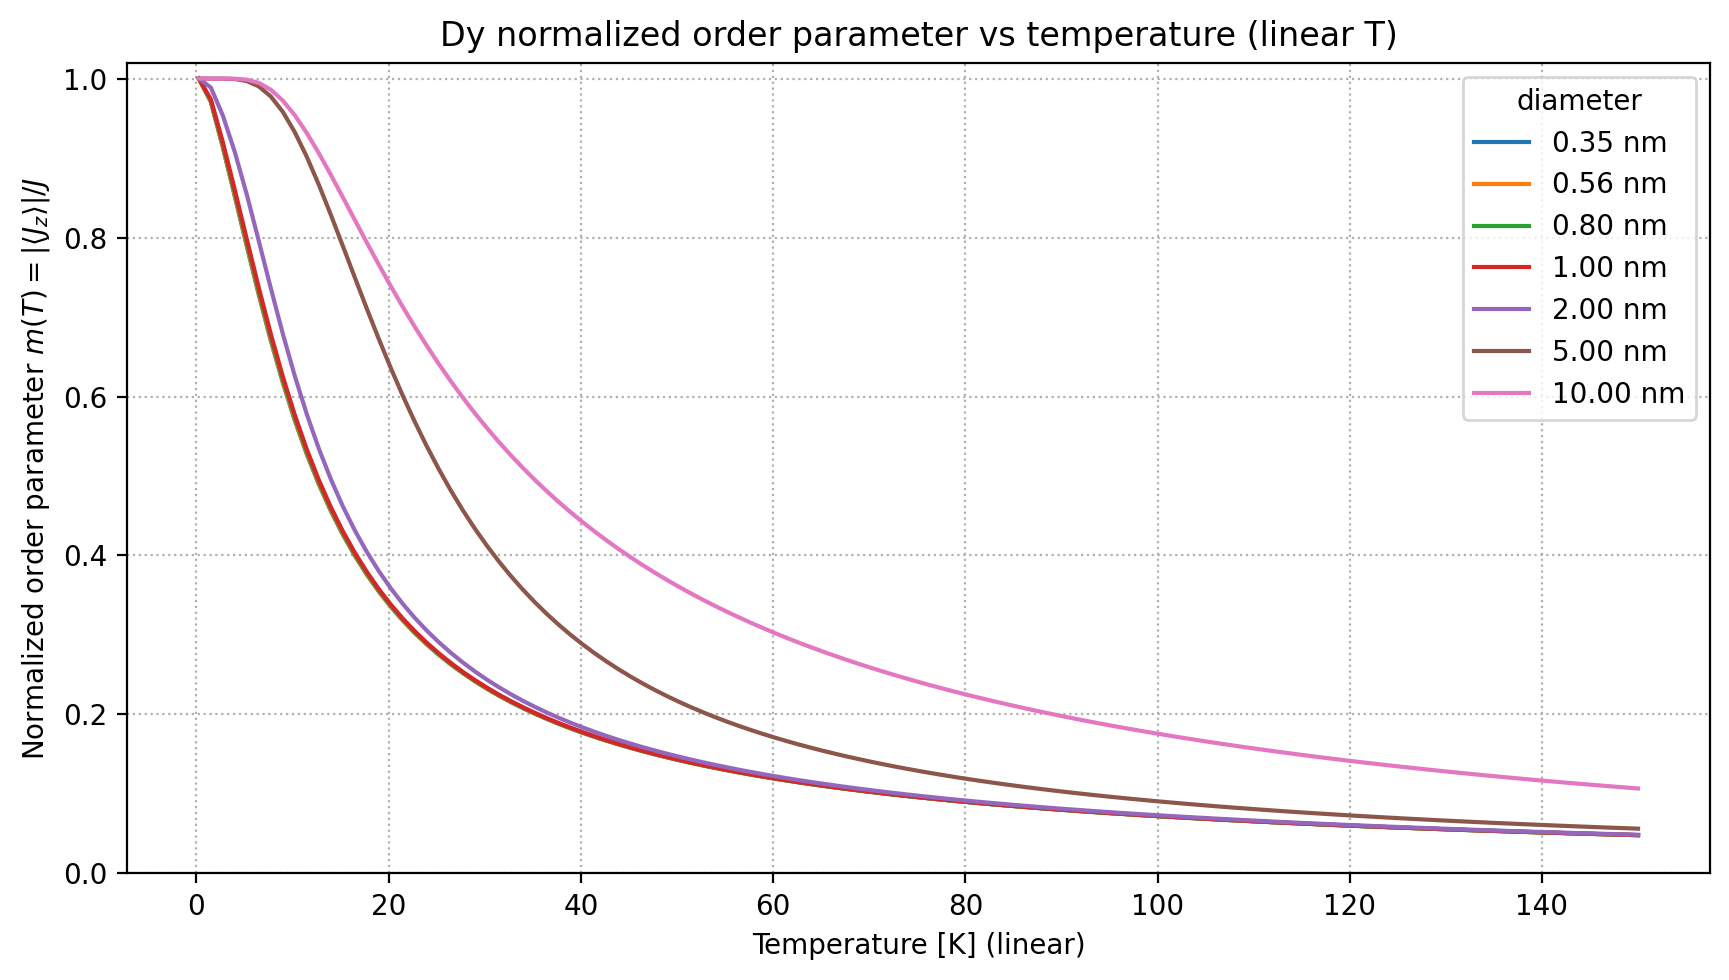

In [ ]:
# --------------------------------------------------------------
# 11) Choose sizes and run the **GPU simulation** (linear T)
# --------------------------------------------------------------
molecules_nm    = [0.35, 0.56, 0.80]        # molecules (sub-nm)
nanoparticles_nm= [1.0, 2.0, 5.0, 10.0]     # nanoparticles
sizes_nm = molecules_nm + nanoparticles_nm

diameters, temps, results = sweep_sizes_and_temps_linear(sizes_nm, KNOBS)
fig, ax = plot_m_linear(diameters, temps, results)
onset_tbl = summarize_onsets(diameters, temps, results, thresholds=KNOBS.onset_thresholds)